<a href="https://colab.research.google.com/github/doopees/social-distancing-monitor/blob/main/notebook/social_distancing_monitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Social distancing monitor

This project aims to detect people on video who do not comply with the minimum distance of 2 meters between people, a safety measure intended to limit the advance of COVID-19.

![](https://raw.githubusercontent.com/doopees/social-distancing-monitor/main/media/screenshot.png)

* Demonstrative video: https://youtu.be/pm3YnYfA7as
* GitHub repository: https://github.com/doopees/social-distancing-monitor

## Preliminaries

### Get the test database

In [1]:
!wget https://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentreXVID.avi
!wget https://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentre-output-HOGHeads.top

--2021-05-10 22:34:13--  https://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentreXVID.avi
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-05-10 22:34:13 ERROR 404: Not Found.

--2021-05-10 22:34:13--  https://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentre-output-HOGHeads.top
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-05-10 22:34:14 ERROR 404: Not Found.



### Writing the code for the local library `monitor.py` that implements the social distancing monitor

In [2]:
#@title Double click here to show/hide the code
%%writefile monitor.py
# Import from standard library
from queue import Queue
from random import choice
from time import time, sleep
from threading import Thread
from operator import attrgetter
from itertools import combinations

# Import third party libraries
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Set seaborn style
sns.set_style('ticks')


# Define some constants
fps = 25
RED = (0, 0, 255)
BLUE = (255, 0, 0)
YELLOW = (0, 255, 255)


class FileVideoStream:
    """Allows fast video streaming with OpenCV by using multithreading."""

    def __init__(self, path, queue_size=128):
        """
        Initialize the file video stream and set the boolean used to
        indicate if the thread should be stopped or not.
        Input
            path: the path to the video file
            queueSize: the maximum number of frames to store in the queue
        """
        self.stream = cv2.VideoCapture(path)
        self.stopped = False
        self.queue = Queue(maxsize=queue_size)

    def start(self):
        """Start a thread to read frames from the file video stream."""
        thread = Thread(target=self.update, args=())
        thread.daemon = True
        thread.start()

    def update(self):
        """
        Read and decode frames from the video file and maintain the
        queue data structure.
        """
        while True:
            sleep(0.001)
            if self.stopped:
                break
            if not self.queue.full():
                # Read the next frame from the file and resize it
                grabbed, frame = self.stream.read()
                frame = cv2.resize(frame, (960, 540))
                # If the end of the video has been reached
                if not grabbed:
                    self.stop()
                    break
                # Add the frame to the queue
                self.queue.put(frame)

    def read(self):
        """Return the next frame in the queue."""
        return self.queue.get()

    def stop(self):
        """Indicate that the thread should be stopped."""
        self.stopped = True

    def running(self):
        """Indicate that the video stream has not finished yet."""
        return not self.stopped


class Person:
    """A person that appears in the video stream"""

    def __init__(self, id_):
        """
        Create a Person object and set his frames and encountered
        dictionaries to be initially empty.
        self.frames has the frames in which the person appears as keys,
        and the number of persons within 2 meters of him as the
        corresponding values.
        self.encountered has the persons encountered (distance inferior
        to 2 meters) as keys, and the number of frames spent close to the
        other person as values.
        Input
            id_: the identfier of the person
        """
        self.id = id_
        self.encountered = {}
        self.frames = {}

    def __repr__(self):
        """Return the string representation of the person."""
        return f'Person {self.id}'

    def set_info(self, center, position, rectangle):
        """
        Set some additional attributes to the person.
        Input
            center: a tuple(x, y) corresponding to the center of
                    the bounding box of the person
            position: a tuple (x, y) corresponding to the coordinates
                      of the person's feet, as this is used to represent
                      location
            rectangle: the list [(x_left, y_top), (x_right, y_bot)]
                       representing two corners of the person's bounding box
        """
        self.center = center
        self.position = position
        self.rectangle = rectangle

    def dataframe(self):
        """
        Return a dataframe with columns time and persons_within_2m.
        time contains the time instants in which the person appears in
        the video.
        persons_within_2m indicates how many persons are close at the
        corresponding time.
        """
        time = list(self.frames.keys())
        time = [t/fps for t in time]
        persons = list(self.frames.values())
        df = pd.DataFrame(data=[time, persons]).T
        df.columns = ('time', 'persons_within_2m')
        return df

    def scatterplot(self):
        """
        Show the scatter plot for the dataframe returned by
        self.dataframe().
        """
        df = self.dataframe()
        sns.scatterplot(x='time', y='persons_within_2m', data=df)
        sns.despine(trim=True)
        plt.show()

    def pieplot(self):
        """
        Show a pie chart with two slices corresponding to the total time
        in which the person is safe (no other person within 2 meters) and the
        total time in which the person is at risk.
        """
        frames_safe = self.num_frames - self.num_frames_exposed
        frames_risk = self.num_frames_exposed
        plt.pie([frames_safe, frames_risk], labels=['safe', 'at_risk'],
                shadow=True, autopct='%1.2f%%',
                wedgeprops=dict(linewidth=1, ec='k'))
        plt.title(f'person {self.id} status on {self.screen_time} s')
        plt.show()

    def add_frame(self, nframe):
        """
        Add a new frame in which the person appears to the frames
        dictionary and set the number of surrounding persons to zero.
        Input
            nframe: the frame number to add
        """
        self.frames[nframe] = 0

    def show_worst_frame(self, painter, by='others', show=True):
        """
        Display the worst frame for the person as defined by by.
        A blue bounding box is drawn around the person to identify him.
        Input
            by: a string indicating the desired worst frame to show
                'others': the worst frame is defined as the frame with
                          the largest number of persons within 2 meters.
                'time': actually used the same frame as 'others', but displays
                        diferent labels. Not meant to use when calling this
                        method by itself. Instead, just serves as an utility
                        parameter for other methods that call this method.
                Defaults to 'others'.
            show: a boolean indicating if it is desired to actually display the
                  worst picture. Not meant to use then calling show_worst_frame
                  by itself. Defaults to True.
        """
        copy = self.worst_picture.copy()
        (nframe, nwithin), time = self.worst_frame, self.time_exposed
        painter.paint_bbox(copy, self.worst_rectangle, 'showing')
        plt.imshow(copy[:,:,::-1])
        plt.title(f'frame {nframe} (time {nframe/fps} s)')
        if by == 'others':
            string = f'Person {self.id} - has {nwithin} persons around'
        if by == 'time':
            string = f'Person {self.id} - exposed for {time} s'
        plt.xlabel(string)
        plt.xticks([])
        plt.yticks([])
        if show:
            plt.show()

    @property
    def num_encounters(self):
        """Return the number of persons encountered."""
        return len(self.encountered)

    @property
    def worst_frame(self):
        """
        Return the tuple (frame_number, num_persons_around)
        corresponding to the frame with the largest number
        of persons arround.
        """
        return max(self.frames.items(), key=lambda x: x[1])

    @property
    def frames_exposed(self):
        """
        Filter the frames dictionary and return a dictionary
        containing just the frames in which the person is exposed.
        """
        return {k:v for k, v in self.frames.items() if v > 0}

    @property
    def num_frames_exposed(self):
        """Return the number of frames in which the person is exposed."""
        return len(self.frames_exposed)

    @property
    def time_exposed(self):
        """Return the total time in which the person is exposed."""
        return self.num_frames_exposed / fps

    @property
    def num_frames(self):
        """Return the number of frames in which the person appears."""
        return len(self.frames)

    @property
    def screen_time(self):
        """Return the total screen time of the person."""
        return self.num_frames / fps


class PersonsContainer:
    """A list-like container for the persons in the video"""

    def __init__(self):
        """
        Initialize the persons dictionary as empty.
        Each entry in the dictionary has a person id as the
        key and the corresponding Person object as the value.
        """
        self.persons = {}

    def __len__(self):
        """Return the current number of persons in the container."""
        return len(self.persons)

    def __contains__(self, id_):
        """
        Check if the person with the given id is contained.
        Input
            id_: the desired person id to check
        """
        return id_ in self.persons

    def __getitem__(self, id_):
        """
        Return the person object with the given id
        Input
            id_: the id of the desired person
        """
        return self.persons[id_]

    def __iter__(self):
        """Return an iterator with all the persons in the container."""
        return iter(self.persons.values())

    def append(self, person):
        """
        Append a new person to the container.
        Input
            person: the Person object to append
        """
        id_ = person.id
        self.persons[id_] = person

    def random_person(self):
        """Return a random person from the container."""
        return choice(list(self.persons.values()))

    def most_exposed(self, by='others', n=1):
        """
        Return the n most exposed persons as defined
        by by
        Input
            by: the criterion by which the most exposed
                persons are defined
                'others': more exposition means more persons
                          encountered.
                'time': more exposition means more time around
                        other persons.
                Defaults to 'others'.
            n: the desired number of most exposed persons to return.
               Defaults to 1.
        """
        if by == 'others':
            getter = attrgetter('num_encounters')
        if by == 'time':
            getter = attrgetter('time_exposed')
        sorted_ = sorted(self, key=getter, reverse=True)
        if n == 1:
            return sorted_[0]
        else:
            return sorted_[:n]

    def show_exposed(self, painter, by='others'):
        """
        Display pictures of the four most exposed persons
        as defined by by.
        Input
            by: the criterion by which the most exposed
                persons are defined
                'others': exposition means persons encountered
                'time': exposition means time around other persons
                Defaults to 'others'
        """
        top = self.most_exposed(by=by, n=4)
        for i, person in enumerate(top):
            plt.subplot(2, 2, i+1)
            person.show_worst_frame(painter, by=by, show=False)
        plt.tight_layout()
        plt.show()

    def dataframe(self):
        """
        Return a dataframe where each entry is a person that
        has appeared on the video and the next columns
            safe: boolean indicating whether the person has
                  been exposed or not
            encounters: number of persons encountered
            time_on_screen: total time on screen
            time_exposed: total time of exposure by being close to others
            worst_time: time instant when the largest number of people
                        are around the person
            max_simult: number of people around on the worst time
        """
        data = []
        cols = ('safe', 'encounters', 'time_on_screen',
                'time_exposed', 'worst_time', 'max_simult')
        for person in self:
            data.append([
                person.num_encounters == 0,
                person.num_encounters,
                person.screen_time,
                person.time_exposed,
                person.worst_frame[0]/fps,
                person.worst_frame[1]
            ])
        df = pd.DataFrame(data, columns=cols)
        df.index.name = 'person'
        return df

    def datapoints(self, by='others', ignore_safe=False):
        """
        Return a pandas series with each entry corresponding
        to a person that has appeared on the video and the
        value associated with each entry being an attribute
        of the person, as defined by by.
        Input
            by: a string defining the attribute of interest
                'others': the attribute is the number of encounters
                'time': time attribute is the time exposed
                Defaults to 'others'.
            ignore_safe: boolean indicating whether to include or not
                         entries for the persons that had not been exposed
                         Defaults to False.
        """
        if by == 'others':
            getter = attrgetter('num_encounters')
            name = 'had contact with x persons'
        if by == 'time':
            getter = attrgetter('time_exposed')
            name = 'exposed for x seconds'
        data = np.array([getter(person) for person in self])
        if ignore_safe:
            data = data[data > 0]
        data = pd.Series(data, name=name)
        data.index.name = 'person id'
        return data

    def dataplot(self, by='others', ignore_safe=False):
        """
        Shows the scatter, swarm and boxplot for the data series
        returned by self.data(by, ignore_safe)
        Input
            by: a string defining the attribute of interest for the plot
                'others': the attribute is the number of encounters
                          Defaults to 'others'
                'time': time attribute is the time exposed
            ignore_safe: boolean indicating whether to include or not
                         the persons that had not been exposed
                         Defaults to False.
        """
        gridspec_kw = {'width_ratios': (3, 1)}
        data = self.datapoints(by, ignore_safe)
        fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridspec_kw)
        sns.scatterplot(y=data, x=data.index, ax=ax1)
        sns.boxplot(y=data, palette='vlag', ax=ax2)
        sns.swarmplot(y=data, color='0.3', ax=ax2)
        ax2.set(ylabel='', yticks=[], xticks=[])
        sns.despine(ax=ax1)
        sns.despine(ax=ax2, left=True)
        fig.subplots_adjust(wspace=0, hspace=0)
        plt.show()

    def hist(self, by='others', ignore_safe=False):
        """
        Shows the histogram for the data series returned by
        self.data(by, ignore_safe).
        Input
            by: a string defining the attribute of interest for the plot
                'others': the attribute is the number of encounters
                          Defaults to 'others'
                'time': time attribute is the time exposed
            ignore_safe: boolean indicating whether to include or not
                         the persons that had not been exposed
                         Defaults to False.
        """
        data = self.datapoints(by, ignore_safe)
        avg_ = data.mean()
        max_ = data.max()
        if by == 'time':
            sns.distplot(data, kde=False, rug=True)
        if by == 'others':
            sns.distplot(data, kde=False, bins=1+max_,
                         hist_kws={'range': (-0.5, 0.5+max_)})
        plt.axvline(avg_, color='k', linestyle='--', linewidth=1)
        min_ylim, max_ylim = plt.ylim()
        if by == 'others':
            string = f'Mean: {avg_:.2f} persons ({len(data)} persons evaluated)'
            xlabel = '# of persons encountered'
        if by == 'time':
            string = f'Mean: {avg_:.2f} s ({len(data)} persons evaluated)'
            xlabel = 'exposure time (s)'
        plt.text(avg_*1.1, max_ylim*0.9, string)
        plt.xlabel(xlabel)
        plt.ylabel('frequency')
        sns.despine(trim=True)
        plt.show()


class Frame:
    """A frame that appears in the video stream"""

    def __init__(self, number):
        """
        Initialize the frame object with its corresponding
        number and an empty dict for the persons in the frame.
        The persons dictionary has persons as keys and whether
        the person is safe or at risk in the frame as values.
        Input
            number: the number of the frame in the video
        """
        self.number = number
        self.persons = {}  # Person: 'safe' or 'at_risk'

    def __setitem__(self, person, state):
        """
        Set the state 'safe' or 'at_risk' for the desired person.
        Input
            person: the person which state is desired to change
            state: the desired state for the person. Possible values
                   are 'safe' and 'at_risk'.
        """
        self.persons[person] = state

    def __repr__(self):
        """Return the string representation of the frame."""
        return f'Frame {self.number}'

    @property
    def safe_persons(self):
        """Return the Person objects in the frame with state 'safe'."""
        return [person
                for person, state in self.persons.items()
                if state == 'safe']

    @property
    def at_risk_persons(self):
        """Return the Person objects in the frame with state 'at_risk'."""
        return [person
                for person, state in self.persons.items()
                if state == 'at_risk']

    @property
    def num_persons(self):
        """Return the total number of persons in the frame."""
        return len(self.persons)

    @property
    def num_safe(self):
        """Return the number of safe persons in the frame."""
        return len(self.safe_persons)

    @property
    def num_at_risk(self):
        """Return the number of persons at risk in the frame."""
        return len(self.at_risk_persons)

    @property
    def positions(self):
        """
        Return a list containing the positions for all
        the persons in the frame.
        """
        return [person.position
                for person in self.persons]

    def add_person(self, person):
        """
        Add a new person to the frame and set his status to 'safe'
        Input
            person: the person to add to the frame
        """
        self[person] = 'safe'

    def update_persons_birdviews(self, bird_views):
        """
        Update the (x, y) coordinates of the bird view of every
        person in the frame.
        Input
            bird_views: a list containing the new bird view coordinates
                        for every person in the frame
        """
        for person, bird_view in zip(self.persons, bird_views):
            person.bird_view = bird_view

    def pieplot(self):
        """
        Show a pie chart with the percentage of safe and at risk persons
        in the frame.
        """
        data = [self.num_safe, self.num_at_risk]
        plt.pie(data, labels=['safe', 'at_risk'], shadow=True,
                autopct='%1.2f%%', wedgeprops=dict(linewidth=1, ec='k'))
        plt.title('persons status')
        plt.show()


class FramesContainer:
    """A list-like container for the frames in the video"""

    def __init__(self):
        """
        Initialize the frames list as empty. Each element in the
        list is a Frame object.
        """
        self.frames = []

    def __len__(self):
        """Return the number of frames seen so far."""
        return len(self.frames)

    def __getitem__(self, number):
        """
        Return the frame identified by the given number
        Input
            number: the number of the frame to return
        """
        return self.frames[number]

    @property
    def _safe_at_risk_persons(self):
        """
        Return a list of tuples with each tuple corresponding
        to a frame and with values equal to the number of safe
        and at risk persons in each frame.
        """
        return [(frame_.num_safe, frame_.num_at_risk)
                for frame_ in self.frames]

    def append(self, frame):
        """
        Append a new frame to the frames container.
        Input
            frame: the desired frame to append
        """
        self.frames.append(frame)

    def status_df(self):
        """
        Return a dataframe containing information about the
        number of safe and at risk persons in each frame.
        """
        df = pd.DataFrame(data=self._safe_at_risk_persons,
                          columns=('safe', 'at_risk'))
        df.index = df.index / fps
        df.index.name = 'time'
        return df

    @property
    def _worst(self):
        """Return the frame with the most number of persons at risk."""
        return max(self.frames, key=lambda x: x.num_at_risk)

    def check_if_worst(self, frame, picture, canvas):
        """
        Check if the given frame is the frame with the most
        number of persons at risk. If so, save the picture
        of the frame.
        Input
            frame: the frame to check
            picture: the picture corresponding to the given frame
            canvas: the canvas with the bird views of the persons
                    in the frame
        """
        if frame.num_at_risk == self._worst.num_at_risk:
            self._worst_picture = picture
            self._worst_birdview = canvas

    def stackplot(self):
        """Show the stack plot of the data returned by self.status_df()."""
        df = self.status_df()
        df.plot.area(alpha=0.7)
        sns.despine(trim=True)
        plt.title('persons vs. time')
        plt.xlabel('time (s)')
        plt.ylabel('persons')
        plt.margins(0, 0)
        plt.show()

    def lineplot(self):
        """Show the line plot of the data returned by self.status_df()."""
        df = self.status_df()
        sns.lineplot(data=df)
        sns.despine(trim=True)
        plt.title('persons vs. time')
        plt.xlabel('time (s)')
        plt.ylabel('persons')
        plt.show()

    def pieplot(self):
        """
        Show a pie chart with the percentage of safe and at risk persons
        for all the frames seen.
        """
        df = self.status_df()
        plt.pie(df.sum(), labels=df.columns, shadow=True,
                autopct='%1.2f%%', wedgeprops=dict(linewidth=1, ec='k'))
        plt.title('persons status')
        plt.show()

    def worst_frame(self):
        """Return the frame with the largest number of exposed persons"""
        return self._worst

    def worst_birdview(self):
        return self._worst_birdview

    def show_worst_frame(self):
        """Show the frame with the largest number of exposed persons."""
        frame = self.worst_frame()
        plt.imshow(self._worst_picture[:,:,::-1])
        plt.axis('off')
        plt.grid(False)
        plt.title(f'Frame #{frame.number} ' +
                  f'(Time: {frame.number/fps:.2f} s) - ' +
                  f'{frame.num_at_risk} persons exposed')
        plt.show()

    def show_worst_birdview(self):
        """Show the bird view with the largest number of exposed persons."""
        frame = self.worst_frame()
        canvas = self.worst_birdview()
        plt.imshow(canvas[:,:,::-1])
        plt.axis('off')
        plt.grid(False)
        plt.title(f'Frame #{frame.number} ' +
                  f'(Time: {frame.number/fps:.2f} s) - ' +
                  f'{frame.num_at_risk} persons exposed')
        plt.show()

    def random_frame(self):
        """Return a random person from the container."""
        return choice(list(self.frames))


class Calculator:
    """A calculator for performing operations on the video data."""

    def __init__(self, corners, targets, canvas_shape):
        """
        Initialize the calculator. self.matrix stores the transformation
        matrix used to calculate the bird view points for each position.
        Input
            corners: the corners of the road as seen in the camera view
            targets: the desired new positions in the canvas for the
                     corners of the street
            canvas_shape: a tuple with the dimensions of the canvas (w, h)
        """
        self.matrix = cv2.getPerspectiveTransform(corners, targets)
        self.shape = canvas_shape

    def process(self, left, top, right, bottom):
        """
        Return the center of the bounding box, the position (defined by
        coordinates of feet) and the corners of the bounding box for a
        single person.
        Input
            left: x coordinate of the left side of the bounding box
            top: y coordinate of the top side of the bounding box
            right: x coordinate of the right side of the bounding box
            bottom: y coordinate of the bottom side of the bounding box
        """
        center = [(left+right) // 2, (top+bottom)//2]
        position = [(left+right)//2, bottom]
        rectangle = [(left, top), (right, bottom)]
        return center, position, rectangle

    def get_bird_views(self, positions):
        """
        Return a list containing the (x, y) coordinates of the
        bird view of every position given in positions.
        Input
            positions: an array of the positions for which the bird view
                       is desired
        """
        bird_views = np.float32([positions])
        bird_views = cv2.perspectiveTransform(bird_views, self.matrix,
                                              self.shape)
        bird_views = np.squeeze(bird_views).astype('int32')
        return bird_views

    def get_at_risk_pairs(self, frame):
        """
        Return a list with every pair of persons withing 2 meters
        one of each other for the given frame.
        No repeated pairs are returned.
        Input
            frame: the frame for which it is wanted to find all
                   exposed pairs
        """
        pairs = []
        persons = frame.persons.keys()
        bird_views = [person.bird_view for person in persons]
        zipped = zip(persons, bird_views)
        for (p1, bv1), (p2, bv2) in combinations(zipped, 2):
            if np.linalg.norm(bv1 - bv2) < 43:
                pairs.append((p1, p2))
        return pairs

    def update_pair_info(self, frame, picture, p1, p2):
        """
        Update information for the given pair. If it's the first
        time they encounter, add each person to the other person
        encountered dictionary. Else, increment the number of times
        they've encountered each other.
        Input
            frame: the Frame object in which the pair appears
            picture: the picture of the given frame
            p1: person one of the pair
            p2: person two of the pair
        """
        self.update_person_info(frame, picture, p1)
        self.update_person_info(frame, picture, p2)
        if p1 not in p2.encountered:
            p1.encountered[p2] = 1
            p2.encountered[p1] = 1
        else:
            p1.encountered[p2] += 1
            p2.encountered[p1] += 1

    def update_person_info(self, frame, picture, person):
        """
        Set the person status to 'at_risk', increment the
        number of persons by which the person is surrounded by
        and determine whether the given frame corresponds to the
        worst frame for the person. If that's the case, save the
        frame picture as the worst picture for the person.
        Input
            frame: the frame object in which the person appears
            picture: the picture of the frame
            person: the person to update
        """
        frame[person] = 'at_risk'
        person.frames[frame.number] += 1
        if person.frames[frame.number] == person.worst_frame[1]:
            person.worst_picture = picture
            person.worst_rectangle = person.rectangle


class Painter:
    """Auxiliary class to paint shapes on pictures"""

    def __init__(self):
        """Initialize the painter."""
        pass

    def paint_bbox(self, picture, rectangle, status):
        """
        Paint the bounding box of a person in the frame.
        Input
            picture: the picture on which the painting is to be
                     performed
            rectangle: the corners of the bounding box
            status: 'safe' or 'at_risk', controls the color of
                    the bounding box
        """
        color = self.get_color(status)
        topleft, botright = rectangle
        cv2.rectangle(picture, topleft, botright, color, 3)

    def paint_birdview(self, canvas, bird_view, status):
        """
        Paint the bird_view of a person in the canvas.
        Input
            canvas: the canvas on which the painting is to be
                    performed
            bird_view: the (x, y) coordinates of the bird view
            color: 'safe' or 'at_risk', controls the color of the
                   bounding box
        """
        color = self.get_color(status)
        cv2.circle(canvas, tuple(bird_view), 5, color, -1)

    def paint_connect(self, picture, center1, center2, status):
        """
        Paint a connecting segment between center1 and center2 in the
        given picture.
        Input
            picture: the picture on which the painting is to be
                     performed
            center1: the first point that defines the segment to be painted
            center2: the second point that defines the segment to be painted
            color: 'safe' or 'at_risk', controls the color of the segment
        """
        color = self.get_color(status)
        cv2.line(picture, tuple(center1), tuple(center2), color, 3)

    def get_color(self, status):
        """Return the color corresponding to the given status."""
        return {
            'safe': YELLOW,
            'at_risk': RED,
            'showing': BLUE
        }.get(status)


def get_frames_data():
    """
    Return an iterator with each iteration returning the information
    about the current frame. Each information batch is a 2D numpy
    arrays of six columns, where for each column corresponds to
    id, frame, body_left, body_top, body_right and body_bottom respectively,
    and number of rows equal to the number of persons in the current frame.
    """
    cols = ['id', 'frame', 'body_left', 'body_top',
            'body_right', 'body_bottom']

    unused = ['head_valid', 'body_valid', 'head_left',
              'head_top', 'head_right', 'head_bottom']

    df = pd.read_csv('TownCentre-groundtruth.top', header=None)

    df = df.drop([2, 3, 4, 5, 6, 7], axis=1)
    df.iloc[:, -4:] = df.iloc[:, -4:] / 2
    df = df.astype(int)
    df.columns = cols

    nframes = max(df['frame'])
    frames_data = [df[df.frame == nframe] for nframe in range(nframes)]
    frames_data = [np.array(df) for df in frames_data]
    return iter(frames_data)

Writing monitor.py


### Importing `monitor.py` and initialize the random number generator

In [3]:
from monitor import *
from random import seed
seed(5)

### Defining some constants and an auxilary function

In [4]:
RED = (0, 0, 255)
BLUE = (255, 0, 0)
YELLOW = (0, 255, 255)

def imshow_bgr(bgr_img):
    rgb_img = bgr_img[:,:,::-1]
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_img)
    plt.axis('off')

### Showing the first frame of the video

Original image size: 1920x1080


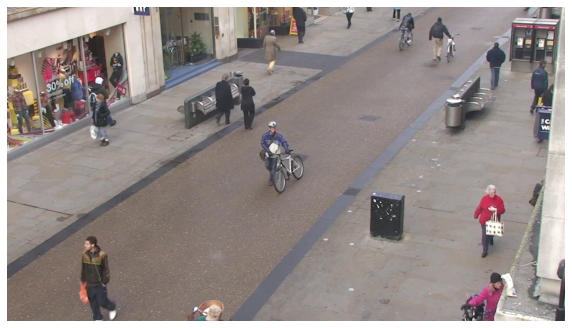

In [5]:
cap = cv2.VideoCapture('TownCentreXVID.avi')
grabbed, frame = cap.read()

print(f'Original image size: {frame.shape[1]}x{frame.shape[0]}')
imshow_bgr(frame)

Due to space constraints on the notebook, it is preferred to work with an image half the size of the original one.

In [6]:
frame = cv2.resize(frame, dsize=(960, 540), interpolation=cv2.INTER_CUBIC)
print(f'New image size: {frame.shape[1]}x{frame.shape[0]}')

New image size: 960x540


### Reading the positions of the passers-by

Since the image size was reduced by a factor of two, it is necessary to do the same with the coordinates in the CSV file.

In [7]:
cols = ['id', 'frame', 'head_valid', 'body_valid',
        'head_left', 'head_top', 'head_right', 'head_bottom',
        'body_left', 'body_top', 'body_right', 'body_bottom']

df = pd.read_csv('TownCentre-groundtruth.top', header=None, names=cols)
df = df.drop(['head_valid', 'body_valid'], axis=1)
df.iloc[:, -8:] = 0.5 * df.iloc[:, -8:]
df = df.astype(int)
df

,id,frame,head_left,head_top,head_right,head_bottom,body_left,body_top,body_right,body_bottom
0,0,0,135,397,154,417,117,385,185,550
1,1,0,154,151,165,163,142,145,185,246
2,2,0,153,120,164,131,143,115,182,208
3,3,0,369,115,379,126,359,110,393,204
4,4,0,407,123,417,134,396,117,430,213
...,...,...,...,...,...,...,...,...,...,...
71455,226,4500,255,121,265,132,245,115,281,209
71456,227,4500,798,261,812,277,777,253,826,385
71457,228,4500,586,267,601,283,572,259,615,393
71458,229,4500,328,142,339,154,317,137,354,237


## Calculating the transformation matrix

### Showing the reference points

The rectangle whose corners were taken as reference to find the transformation matrix is shown in blue. The bounding box for each person in the image is also shown.

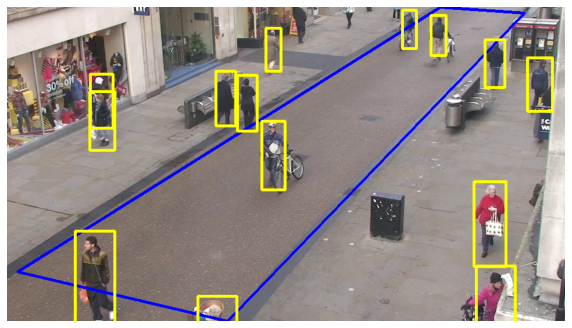

In [8]:
copy = frame.copy()

corners = np.float32([[745, 0], [890, 10], [379, 540], [18, 455]])
corners_ = corners.reshape((-1, 1, 2)).astype('int32')
cv2.polylines(copy, [corners_], isClosed=True, color=BLUE, thickness=3)

frame_df = df[df.frame == 0]

for _, row in frame_df.iterrows():
    top_left = (row.body_left, row.body_top)
    bot_right = (row.body_right, row.body_bottom)
    cv2.rectangle(copy, top_left, bot_right, color=YELLOW, thickness=3)

imshow_bgr(copy)

### Finding the transformation matrix

The ``targets`` array defines the coordinates in the bird-eye view to which the four landmarks defined above are mapped. To find this array, the street was measured in Google Maps to be approximately 20 meters long and 15 meters wide (5 meters are track), and this information was used to find the mapping of the reference points to a 371x528 image, the dimensions of the image containing the bird-eye view of the people.

In [9]:
top_left = np.float32([127, 0])  # Bird-eye view from the upper left corner
targets = top_left + np.float32([[0, 0], [117, 0], [117, 528], [0, 528]])
matrix = cv2.getPerspectiveTransform(corners, targets)

print('Transformation matrix:')
print(matrix)

Transformation matrix:
[[ 7.44571240e-01  1.70429784e+00 -4.29113372e+02]
 [-2.04195558e-01  2.96083560e+00  1.52125691e+02]
 [-1.48792346e-05  4.02835406e-03  1.00000000e+00]]


## Showing the perspective transform

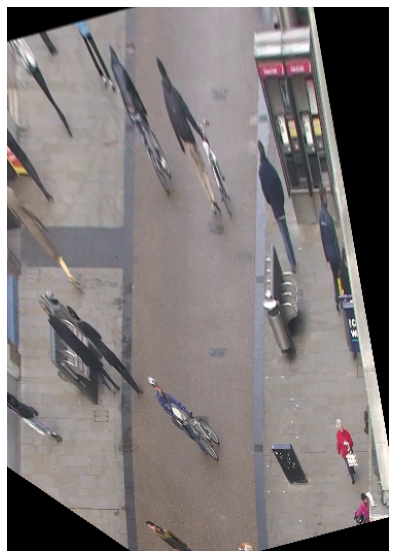

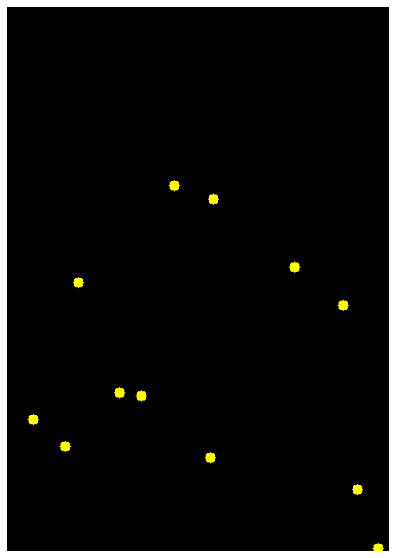

In [10]:
# Define the canvas on which the
# bird-eye view will be displayed.
w, h = 371, 528
canvas = np.zeros((h, w, 3), dtype='uint8')

# The position of a person is defined by the (x, y) coordinates
# of the midpoint of the lower segment of its bounding box.
people_positions = []

# The position of each person in the frame is stored
# in the people_positons list.
for _, person in frame_df.iterrows():
    x = (person.body_left + person.body_right) // 2
    y = person.body_bottom
    people_positions.append([x, y])

# Using the matrix obtained above, a perspective transformation is
# applied to calculate the position of each person in the bird-eye view.
people_positions = np.float32([people_positions])
bird_view_pos = cv2.perspectiveTransform(people_positions, matrix, (w, h))
bird_view_pos = np.squeeze(bird_view_pos).astype('int32')

# A circle is plotted at each position of the people in the bird-eye view.
for position in bird_view_pos:
    cv2.circle(canvas, tuple(position), 5, YELLOW, -1)

# The same transformation is applied to the original image
# for illustrative purposes.
warped = cv2.warpPerspective(frame, matrix, (w, h))

# Show the resulting images
imshow_bgr(warped)
imshow_bgr(canvas)

## Monitoring social distancing compliance on video

The `monitor` library provides the necessary classes for this task. The `monitor.py` file contains the documentation for each class. The following code is adapted from the `main.py` script (found in this project's repository).

### Analyzing the video

In [11]:
# Initialize the utility classes
frames = FramesContainer()
persons = PersonsContainer()
calculator = Calculator(corners, targets, (w, h))
painter = Painter()

# Get the iterator with the data of each frame
frames_data = get_frames_data()

# Initialize the video stream
stream = FileVideoStream('TownCentreXVID.avi')

# Start the stream
nframe = 0
stream.start()

# Get the initial time and save it
timestamp = time()
start = timestamp

# Loop over frames from the video stream
while stream.running():
    # If there is no more information left, exit the loop
    try:
        frame_info = next(frames_data)
    except:
        break

    # Grab the current frame
    picture = stream.read()

    # Make the current frame object
    frame = Frame(nframe)

    # For every person in the frame
    for person_info in frame_info:
        # Get the person's information
        person_id, _, left, top, right, bot = person_info
        # Create the person object if appearing for first time
        if person_id not in persons:
            person = Person(person_id)
            # Add the new person object to the container
            persons.append(person)
        else:
            # Else, fetch the person from the persons container
            person = persons[person_id]
        # Calculate the center, position and bounding box of the person
        center, position, rectangle = calculator.process(left, top, right, bot)
        # Add the calculated information to the person object
        person.set_info(center, position, rectangle)
        # Add the current frame to the person object, and vice versa
        person.add_frame(nframe)
        frame.add_person(person)

    # Calculate the bird view for every person in the frame
    # and update their bird_view attribute
    bird_views = calculator.get_bird_views(frame.positions)
    frame.update_persons_birdviews(bird_views)

    # Create the canvas over which the bird view points are to
    # be painted
    canvas = np.zeros((h, w, 3), dtype='uint8')

    # For every person in the frame, paint their bounding box
    # and bird view. Initially, it is asumed that the person in safe.
    for person in frame.persons:
        painter.paint_bbox(picture, person.rectangle, 'safe')
        painter.paint_birdview(canvas, person.bird_view, 'safe')

    # Get the pairs of persons that are close to each other
    at_risk_pairs = calculator.get_at_risk_pairs(frame)

    # For every pair found, paint thei bounding box, bird view
    # connect their centers in the camera view and their positions
    # in the bird eye view. It is no longer asumed that the persons are safe.
    for p1, p2 in at_risk_pairs:
        painter.paint_bbox(picture, p1.rectangle, 'at_risk')
        painter.paint_bbox(picture, p2.rectangle, 'at_risk')
        painter.paint_birdview(canvas, p1.bird_view, 'at_risk')
        painter.paint_birdview(canvas, p2.bird_view, 'at_risk')
        painter.paint_connect(picture, p1.center, p2.center, 'at_risk')
        painter.paint_connect(canvas, p1.bird_view, p2.bird_view, 'at_risk')
        # Update the pair info
        calculator.update_pair_info(frame, picture, p1, p2)

    # Append the current frame to the frames container, and check
    # if it is the worst frame seen so far, as in the frame with
    # the largest number of persons exposed.
    frames.append(frame)
    frames.check_if_worst(frame, picture, canvas)

    timestamp = time()
    nframe += 1

# Show the duration of the displayed video
print(f'Analysis took {timestamp-start:.2f} seconds')

Analysis took 68.78 seconds


In [12]:
print('Total number of frames analyzed:', len(frames))

Total number of frames analyzed: 4500


In [13]:
print('Number of people in the video:', len(persons))

Number of people in the video: 230


### Showing the bird's-eye view of the frame with the highest number of exposed people.

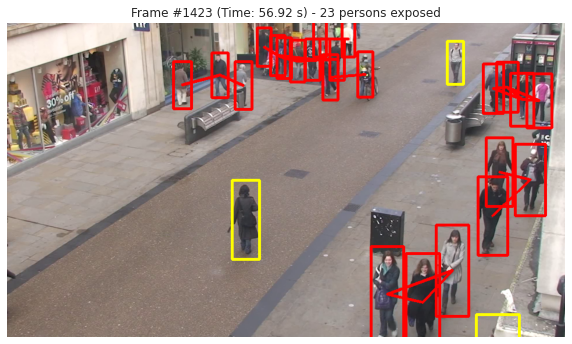

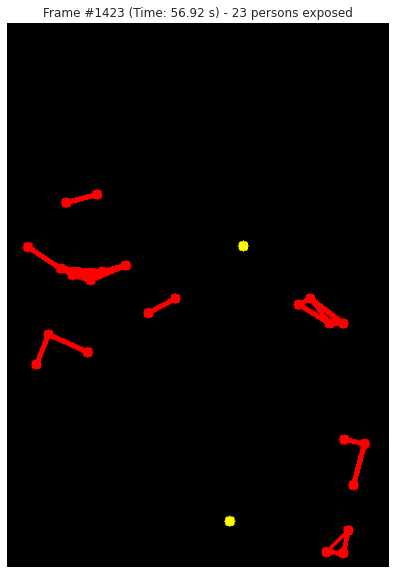

In [14]:
plt.figure(figsize=(10, 10))
frames.show_worst_frame()

plt.figure(figsize=(10, 10))
frames.show_worst_birdview()

It can be seen that at this frame almost all of the people are close to each other. In total, there are 23 people exposed to contagion, the maximum number of people exposed in any frame of the video.

## Extras

### Displaying general information about all the frames of the video

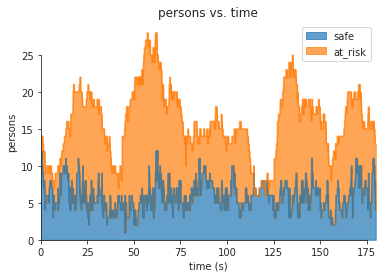

In [15]:
frames.stackplot()

It can be observed that most of the time the number of people who do not respect the distancing is higher than those who do.

A pie chart better illustrates the ratio of those who are at safe distance to those who are not.

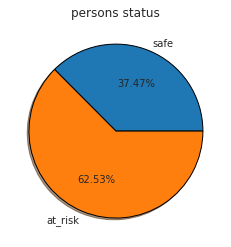

In [16]:
frames.pieplot()

Almost 63% of the people in the video do not respect social distancing. The table below summarizes every frame of the video.

In [17]:
frames.status_df()

,safe,at_risk
time,,
0.00,8,6
0.04,8,6
0.08,10,4
0.12,10,4
0.16,12,2
...,...,...
179.80,4,9
179.84,4,9
179.88,4,9


### Visualizing general information of all the people in the video

Showing the 10 most exposed people according to the number of people they were exposed to.

In [18]:
top10_others = persons.most_exposed(by='others', n=10)

print('Person\t\tExposed to')
print('-------\t\t---------------')
for person in top10_others:
    print(f'id {person.id}\t\t{person.num_encounters} people')

Person		Exposed to
-------		---------------
id 161		16 people
id 58		15 people
id 68		15 people
id 75		14 people
id 177		14 people
id 55		13 people
id 70		13 people
id 178		12 people
id 190		12 people
id 73		11 people


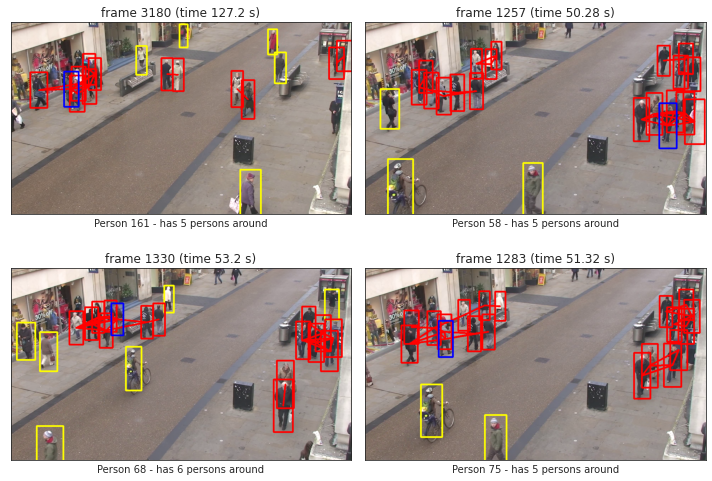

In [19]:
plt.figure(figsize=(10, 7))
persons.show_exposed(painter, by='others')

Showing the top 10 most exposed people according to the amount of time they were exposed to other people.

In [20]:
top10_time = persons.most_exposed(by='time', n=10)

print('Person\t\tExposed for')
print('-------\t\t------------')
for person in top10_time:
    print(f'id {person.id}\t\t{person.time_exposed} seconds')

Person		Exposed for
-------		------------
id 58		27.68 seconds
id 55		27.56 seconds
id 196		22.12 seconds
id 33		21.04 seconds
id 190		20.68 seconds
id 199		20.52 seconds
id 35		19.96 seconds
id 134		19.92 seconds
id 135		19.92 seconds
id 28		19.72 seconds


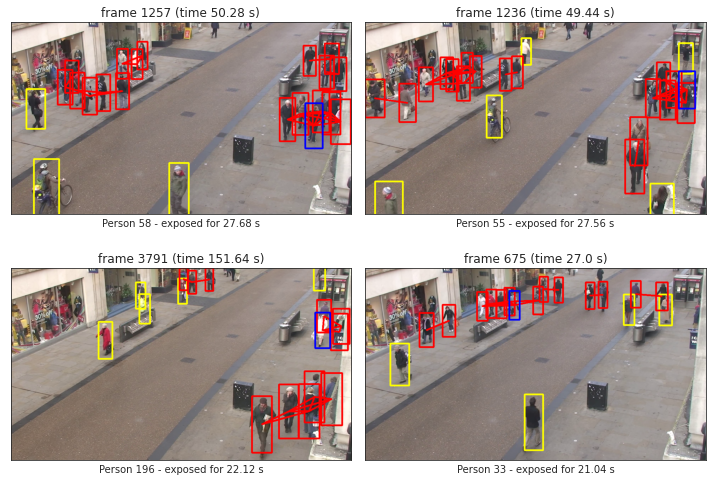

In [21]:
plt.figure(figsize=(10, 7))
persons.show_exposed(painter, by='time')

It is expected that the exposure time is longer the more people you have been exposed to. To corroborate this, the following graph is constructed.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


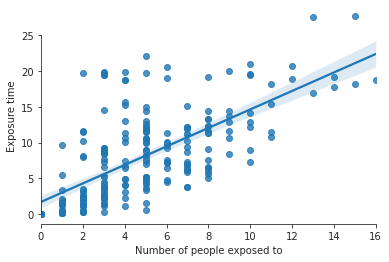

In [22]:
encounters = [person.num_encounters for person in persons]
times = [person.time_exposed for person in persons]

sns.regplot(encounters, times)
plt.xlabel('Number of people exposed to')
plt.ylabel('Exposure time')
sns.despine(trim=True)

Linear regression shows that, in general, as the number of people someone is exposed to increases, their total exposure time also increases. However, there are points where the number of people being exposed is small, but the exposure time is large. These points correspond to people who happen to be accompanied.

**Box plots**

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 9.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


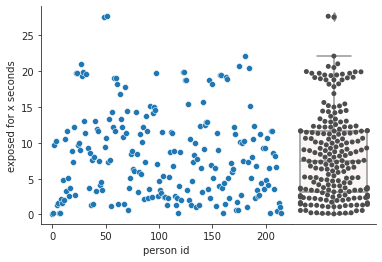

In [23]:
persons.dataplot(by='time', ignore_safe=True)

It can be observed that 75% of the people have an exposure time of 12 seconds or less.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 46.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


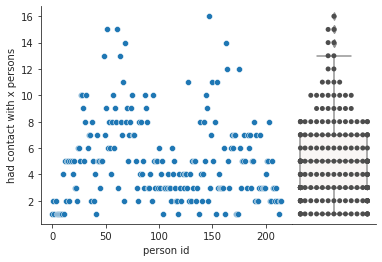

In [24]:
persons.dataplot(by='others', ignore_safe=True)

It can be observed that 75% of the people have contact with at most 7 people.

**Histograms**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


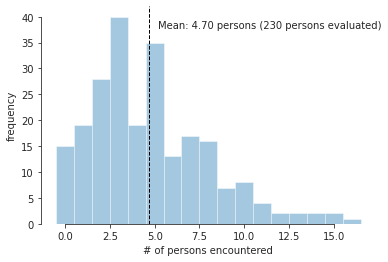

In [25]:
persons.hist(by='others')

On average, people have contact with 4.5 other people.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


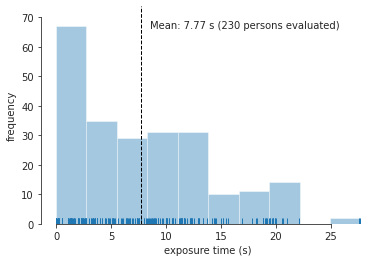

In [26]:
persons.hist(by='time')

On average, people are exposed for 7.77 seconds, although most do not exceed 2.5 seconds.

All of the information about the people on the video can be summarized in the table below.

In [27]:
persons.dataframe()

,safe,encounters,time_on_screen,time_exposed,worst_time,max_simult
person,,,,,,
0,True,0,1.48,0.00,0.00,0
1,False,1,2.12,0.08,0.00,1
2,False,2,10.48,0.24,0.00,1
3,False,1,9.68,9.68,0.00,1
4,False,2,10.24,10.24,9.08,2
...,...,...,...,...,...,...
225,False,2,4.40,0.52,175.60,1
226,False,1,4.24,1.64,176.20,1
227,False,2,4.00,1.08,177.16,1
